In [1]:
import numpy as np
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from typing import Union, List, Literal
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time


import logistic_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

np.random.seed(44)  # for comparison of results

In [2]:
def confusion_matrix(
    y_true: Union[np.ndarray, pd.DataFrame], y_pred: Union[np.ndarray, pd.DataFrame]
) -> np.ndarray:
    """
    function returns confusion matrix

    """
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    TP = np.sum(y_true & y_pred)
    TN = np.sum(~y_true & ~y_pred)
    FP = np.sum(~y_true & y_pred)
    FN = np.sum(y_true & ~y_pred)

    return np.array([[TP, FP], [FN, TN]])


def balanced_accuracy(
    y_true: Union[np.ndarray, pd.DataFrame], y_pred: Union[np.ndarray, pd.DataFrame]
) -> float:
    """
    function returns balanced accuracy of classification
    """

    conf = confusion_matrix(y_true, y_pred)
    TPR = conf[0, 0] / (conf[0, 0] + conf[1, 0])
    TNR = conf[1, 1] / (conf[1, 1] + conf[0, 1])

    return 0.5 * (TPR + TNR)

In [3]:
def compare_methods(
    X: Union[np.ndarray, pd.DataFrame],
    y: Union[np.ndarray, pd.DataFrame],
    k=5,
    test_size=0.2,
    interaction=False,
):
    """
    function compares performance of several build-in classification models

    """
    methods = ["decision tree", "random forest", "LDA", "QDA"]
    optimizers = ["sgd", "adam", "iwls"]
    results = {}

    for iteration in range(k):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=iteration
        )

        for method in methods:
            if method == "LDA":
                model = LinearDiscriminantAnalysis()
            elif method == "QDA":
                model = QuadraticDiscriminantAnalysis()
            elif method == "decision tree":
                model = DecisionTreeClassifier()
            elif method == "random forest":
                model = RandomForestClassifier()

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            results[method] = results.get(method, []) + [
                balanced_accuracy(y_test, y_pred)
            ]

        # logistic regression
        for optimizer in optimizers:
            model = logistic_regression.LogisticRegressor(descent_algorithm=optimizer)
            model.fit(X_train, y_train)
            results[optimizer] = results.get(optimizer, []) + [
                model.balanced_accuracy(X_test, y_test)
            ]

        if interaction:
            for optimizer in optimizers:
                model = logistic_regression.LogisticRegressor(
                    descent_algorithm=optimizer, include_interactions=True
                )
                model.fit(X_train, y_train)
                results[optimizer + "_inter"] = results.get(
                    optimizer + "_inter", []
                ) + [model.balanced_accuracy(X_test, y_test)]
    results = pd.DataFrame(results)
    results = results.melt(var_name="Algorithm", value_name="Balanced Accuracy")
    return results

In [4]:
def process_df(name):
    df = pd.read_csv(f"data/{name}.csv")
    if len(df) > 12000:
        print(f"Downsampling {name} to 12000 samples form {len(df)} samples")
        df = df.sample(n=12000)
    df_y = df["target"]
    df_X = df.drop(columns=["target"])
    mean = df_X.mean()
    std = df_X.std()
    df_X = (df_X - mean) / std
    return df_X, df_y

In [5]:
def visualize_balanced_accuracy(metrisc_df, name, folder):
    plt.figure(figsize=(14, 5))
    sns.set_theme(style="whitegrid")
    sns.boxplot(
        data=metrisc_df,
        x="Algorithm",
        y="Balanced Accuracy",
        palette=sns.color_palette("husl", 10),
    )
    plt.title(f"Balanced Accuracy for {name} dataset", fontsize=15)
    plt.xlabel("Algorithm", fontsize=12)
    plt.ylabel("Balanced Accuracy", fontsize=12)
    plt.savefig(f"plots/{folder}/{name}.png")
    plt.show()

In [6]:
X, y = process_df("raisin")
results = compare_methods(X, y, k=2, interaction=False)

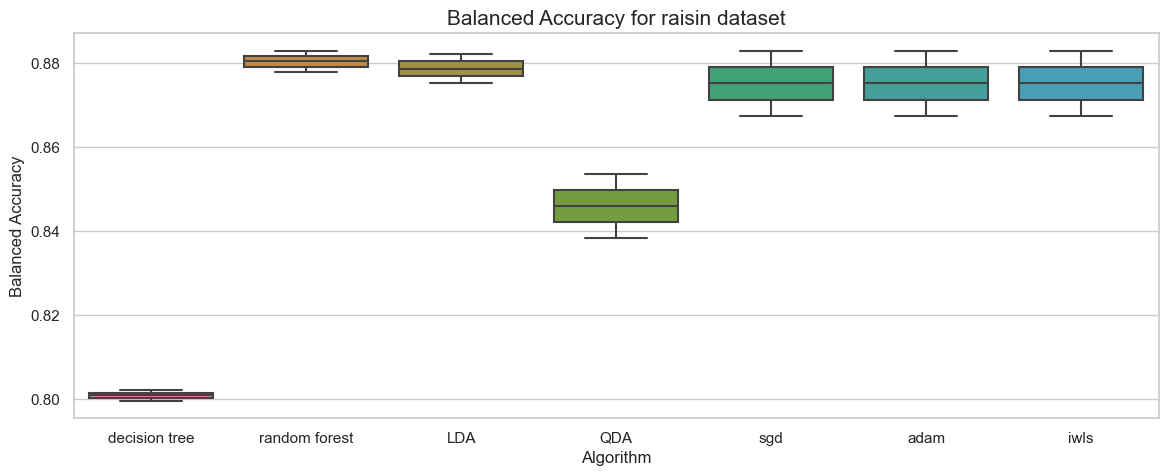

In [8]:
visualize_balanced_accuracy(results, "raisin", "accuracy_comparison")

In [9]:
sets = ["diabetes", "rice", "raisin"]
for name in sets:
    X, y = process_df(name)
    results = compare_methods(X, y, k=10, interaction=True)
    folder = "accuracy_comparison_interactions"
    visualize_balanced_accuracy(results, name, folder)

In [ ]:
sets = ["aids", "campaign", "communities_and_crime", "dry_bean", "heart", "polish_companies_bankruptcy"]
for name in sets:
    X, y = process_df(name)
    results = compare_methods(X, y, k=10, interaction=False)
    folder = "accuracy_comparison"
    visualize_balanced_accuracy(results, name, folder)